<a href="https://colab.research.google.com/github/Koanah/CNNs_rediscovered-/blob/main/U_Net_Luna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install SimpleITK --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 48.0 MB/s eta 0:00:00


In [ ]:
import os, gc, math, random, time
import numpy as np
import pandas as pd
import SimpleITK as sitk
import cv2
import matplotlib.pyplot as plt
from tqdm import trange

import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

BASE_PATH = "/content/drive/MyDrive/LUNA16_trial"
TP_CSV    = os.path.join(BASE_PATH, "true_positive_candidates_secondRun.csv")  # from Stage 2
assert os.path.exists(TP_CSV), f"Missing CSV: {TP_CSV}"
SUBSETS_ROOT = BASE_PATH

Mounted at /content/drive


# Load data (or fail loud)

In [ ]:
def load_required_scans(series_ids, subsets_root=SUBSETS_ROOT):
    """
    Load only scans needed for the given seriesuids; skip missing/corrupt safely.
    Returns dict: {seriesuid: SimpleITK.Image}
    """
    series_set = set(series_ids)
    found = {}
    skipped = []
    for i in range(10):
        subset_dir = os.path.join(subsets_root, f"subset{i}")
        if not os.path.isdir(subset_dir):
            continue
        for fname in os.listdir(subset_dir):
            if not fname.endswith(".mhd"):
                continue
            uid = fname.replace(".mhd", "")
            if uid not in series_set:
                continue
            mhd_path = os.path.join(subset_dir, fname)
            raw_path = mhd_path.replace(".mhd", ".raw")
            if not os.path.exists(raw_path):
                skipped.append(uid)
                continue
            try:
                img = sitk.ReadImage(mhd_path)
                found[uid] = img
            except Exception:
                skipped.append(uid)
    print(f"Loaded {len(found)} scans | Skipped {len(skipped)}")
    return found

#Helper fuctions

In [ ]:
def hu_to_float01(arr, hu_min=-1000, hu_max=400):
    arr = np.clip(arr, hu_min, hu_max).astype(np.float32)
    return (arr - hu_min) / float(hu_max - hu_min + 1e-6)

def crop_patch_and_mask(scan, z_index, x1, y1, x2, y2, patch_size=224, pad=16):
    """
    - Takes one CT slice at z_index
    - Crops a padded box around [x1,y1,x2,y2] (pixel coords in that slice)
    - Builds a binary mask where the bbox is filled (ellipse inside bbox)
    - Returns (H,W,1) float32 image in [0,1] and mask in {0,1}
    """
    arr = sitk.GetArrayFromImage(scan)  # [Z, Y, X]
    Z, H, W = arr.shape
    z = int(np.clip(z_index, 0, Z-1))

    img2d = hu_to_float01(arr[z])  # (H,W)

    # Pad crop window
    x1p = max(0, int(math.floor(x1)) - pad)
    y1p = max(0, int(math.floor(y1)) - pad)
    x2p = min(W, int(math.ceil(x2)) + pad)
    y2p = min(H, int(math.ceil(y2)) + pad)

    crop = img2d[y1p:y2p, x1p:x2p]
    if crop.size == 0:
        return None, None

    # Build mask in crop frame
    mask = np.zeros_like(crop, dtype=np.float32)
    # ellipse inside original bbox translated to crop coords
    cx = (x1 + x2) / 2.0 - x1p
    cy = (y1 + y2) / 2.0 - y1p
    rx = max(1.0, (x2 - x1) / 2.0)
    ry = max(1.0, (y2 - y1) / 2.0)
    # OpenCV wants int ellipse params
    center = (int(round(cx)), int(round(cy)))
    axes   = (int(round(rx)), int(round(ry)))
    try:
        mask_u8 = np.zeros_like(crop, dtype=np.uint8)
        cv2.ellipse(mask_u8, center, axes, angle=0, startAngle=0, endAngle=360, color=1, thickness=-1)
        mask = mask_u8.astype(np.float32)
    except Exception:
        # Fallback: rectangle
        x1c = max(0, int(round(cx - rx))); y1c = max(0, int(round(cy - ry)))
        x2c = min(crop.shape[1], int(round(cx + rx))); y2c = min(crop.shape[0], int(round(cy + ry)))
        if x2c > x1c and y2c > y1c:
            mask[y1c:y2c, x1c:x2c] = 1.0

    # Resize to network size
    img_res = cv2.resize(crop, (patch_size, patch_size), interpolation=cv2.INTER_LINEAR)
    msk_res = cv2.resize(mask, (patch_size, patch_size), interpolation=cv2.INTER_NEAREST)

    img_res = img_res[..., np.newaxis].astype(np.float32)
    msk_res = msk_res[..., np.newaxis].astype(np.float32)
    return img_res, msk_res

# Build dataset from TP CSV

Loaded 334 scans | Skipped 0


Building patches: 100%|██████████| 1116/1116 [00:55<00:00, 20.16it/s]



Dataset ready: X=(1116, 224, 224, 1) Y=(1116, 224, 224, 1) | failures: 0
Positive pixel fraction: 0.07306019216775894


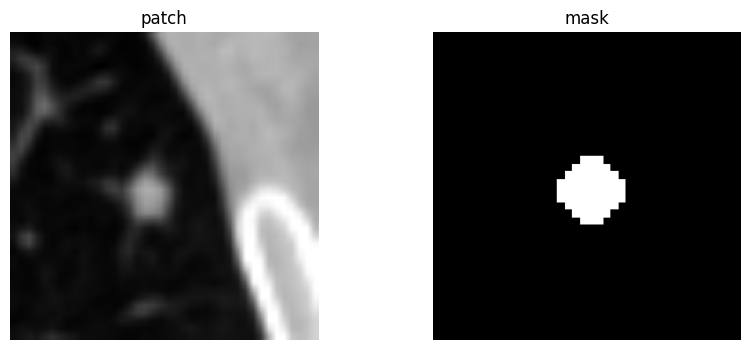

In [ ]:
tp = pd.read_csv(TP_CSV)
# Expect columns: seriesuid, z_index, x1, y1, x2, y2, ...
required_cols = {"seriesuid","z_index","x1","y1","x2","y2"}
missing = required_cols - set(tp.columns)
assert not missing, f"CSV missing columns: {missing}"

series_needed = tp["seriesuid"].unique().tolist()
scans = load_required_scans(series_needed)

patches, masks = [], []
fail = 0
for i in trange(len(tp), desc="Building patches"):
    r = tp.iloc[i]
    uid = r["seriesuid"]
    scan = scans.get(uid, None)
    if scan is None:
        fail += 1; continue
    img, msk = crop_patch_and_mask(
        scan,
        z_index=r["z_index"],
        x1=r["x1"], y1=r["y1"], x2=r["x2"], y2=r["y2"],
        patch_size=224, pad=16
    )
    if img is None:
        fail += 1; continue
    patches.append(img); masks.append(msk)

X = np.asarray(patches, dtype=np.float32)
Y = np.asarray(masks,   dtype=np.float32)
print(f"\nDataset ready: X={X.shape} Y={Y.shape} | failures: {fail}")
print("Positive pixel fraction:", float(Y.mean()))

# Basic sanity: visualize a few
def viz_sample(k=0):
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.imshow(X[k,...,0], cmap='gray'); plt.title("patch"); plt.axis('off')
    plt.subplot(1,2,2); plt.imshow(Y[k,...,0], cmap='gray'); plt.title("mask"); plt.axis('off')
    plt.show()
if len(X) > 0:
    viz_sample(0)

# Train/val spli

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(
    X, Y, test_size=0.2, random_state=42
)
print("Train:", X_train.shape, Y_train.shape)
print("Val  :", X_val.shape, Y_val.shape)

Train: (892, 224, 224, 1) (892, 224, 224, 1)
Val  : (224, 224, 224, 1) (224, 224, 224, 1)


# Paired augmentations (Albumentations) + tf.data pipeline

In [ ]:
BATCH = 8
def aug_fn(img, msk):
    # light, safe 2D aug
    if tf.random.uniform([]) < 0.5:
        img = tf.image.flip_left_right(img); msk = tf.image.flip_left_right(msk)
    if tf.random.uniform([]) < 0.5:
        img = tf.image.flip_up_down(img);    msk = tf.image.flip_up_down(msk)
    return img, msk

def make_ds(X, Y, training=True):
    ds = tf.data.Dataset.from_tensor_slices((X, Y))
    if training:
        ds = ds.shuffle(min(len(X), 2048), reshuffle_each_iteration=True)
        ds = ds.map(lambda a,b: aug_fn(a,b), num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH).prefetch(tf.data.AUTOTUNE)
    return ds

ds_tr = make_ds(X_train, Y_train, training=True)
ds_va = make_ds(X_val,   Y_val,   training=False)

 # UNet model (clean, with BN + Dropout)

In [ ]:
def conv_block(x, f, k=3, s=1, p="same"):
    x = layers.Conv2D(f, k, s, padding=p, use_bias=False)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def encoder_block(x, f):
    y = conv_block(x, f); y = conv_block(y, f)
    p = layers.MaxPool2D()(y)
    return y, p

def decoder_block(x, skip, f):
    x = layers.UpSampling2D()(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, f); x = conv_block(x, f)
    return x

def build_unet(input_shape=(224,224,1)):
    inputs = layers.Input(input_shape)
    s1,p1 = encoder_block(inputs, 32)
    s2,p2 = encoder_block(p1,     64)
    s3,p3 = encoder_block(p2,    128)
    s4,p4 = encoder_block(p3,    256)
    b     = conv_block(p4, 512); b = conv_block(b, 512)
    d1    = decoder_block(b, s4, 256)
    d2    = decoder_block(d1,s3, 128)
    d3    = decoder_block(d2,s2,  64)
    d4    = decoder_block(d3,s1,  32)
    out   = layers.Conv2D(1, 1, activation="sigmoid")(d4)
    return Model(inputs, out, name="UNet2D")

def dice_coef(y_true, y_pred, smooth=1.0):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    inter  = tf.reduce_sum(y_true * y_pred)
    denom  = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    return (2.*inter + smooth) / (denom + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

model = build_unet()
opt = tf.keras.optimizers.Adam(1e-4)
model.compile(optimizer=opt,
              loss=lambda yt, yp: 0.5*tf.keras.losses.binary_crossentropy(yt, yp) + 0.5*dice_loss(yt, yp),
              metrics=[dice_coef])

model.summary()


Model: "UNet2D"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_38 (Conv2D)  │ (None, 224, 224,  │        288 │ input_layer_2[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_38[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_36 (ReLU)     │ (None, 224, 224,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_39 (Conv2D)  │ (None, 224, 224,  │      9,216 │ re_lu_36[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 224, 224,  │        128 │ conv2d_39[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_37 (ReLU)     │ (None, 224, 224,  │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 112, 112,  │          0 │ re_lu_37[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_40 (Conv2D)  │ (None, 112, 112,  │     18,432 │ max_pooling2d_8[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_40[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_38 (ReLU)     │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_41 (Conv2D)  │ (None, 112, 112,  │     36,864 │ re_lu_38[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 112, 112,  │        256 │ conv2d_41[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_39 (ReLU)     │ (None, 112, 112,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 56, 56,    │          0 │ re_lu_39[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 56, 56,    │     73,728 │ max_pooling2d_9[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        512 │ conv2d_42[0][0] 

 Total params: 7,854,913 (29.96 MB)

 Trainable params: 7,849,025 (29.94 MB)

 Non-trainable params: 5,888 (23.00 KB)

# Train


In [ ]:
ckpt_path = os.path.join(BASE_PATH, "best_unet_stage3.keras")
cbs = [
    ModelCheckpoint(ckpt_path, save_best_only=True, monitor="val_loss"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
]

EPOCHS = 25
history = model.fit(ds_tr, validation_data=ds_va, epochs=EPOCHS, verbose=1, callbacks=cbs)

print(f"\nSaved best U-Net to: {ckpt_path}")

Epoch 1/25
112/112 ━━━━━━━━━━━━━━━━━━━━ 30s 114ms/step - dice_coef: 0.2571 - loss: 0.5884 - val_dice_coef: 0.1241 - val_loss: 0.6786 - learning_rate: 1.0000e-04
Epoch 2/25
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - dice_coef: 0.4159 - loss: 0.4066 - val_dice_coef: 0.1583 - val_loss: 0.5743 - learning_rate: 1.0000e-04
Epoch 3/25
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - dice_coef: 0.4693 - loss: 0.3583 - val_dice_coef: 0.2888 - val_loss: 0.6745 - learning_rate: 1.0000e-04
Epoch 4/25
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - dice_coef: 0.5025 - loss: 0.3309 - val_dice_coef: 0.3901 - val_loss: 0.4226 - learning_rate: 1.0000e-04
Epoch 5/25
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - dice_coef: 0.5387 - loss: 0.3060 - val_dice_coef: 0.4651 - val_loss: 0.4005 - learning_rate: 1.0000e-04
Epoch 6/25
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - dice_coef: 0.5728 - loss: 0.2812 - val_dice_coef: 0.4820 - val_loss: 0.3314 - learning_rate: 1.0000e-04
Epoch 7/25
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 2

# sanity plots nyana

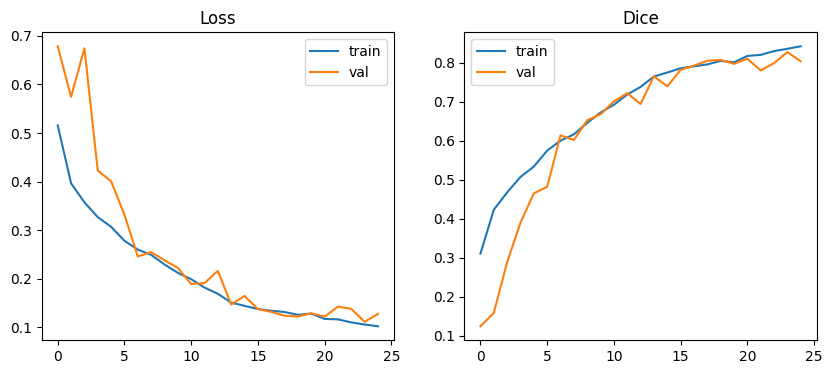

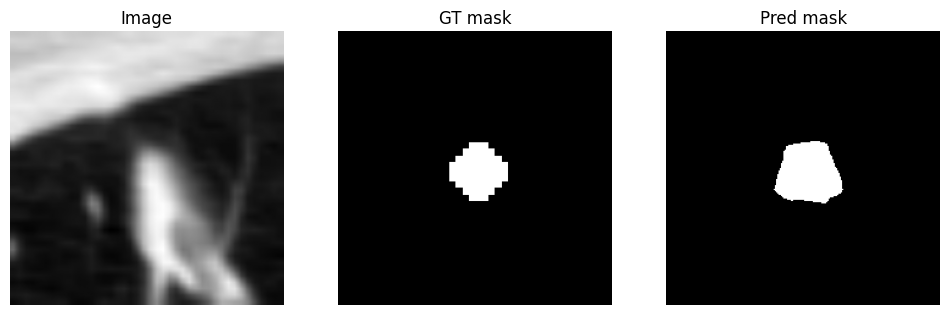

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(history.history["loss"], label="train"); plt.plot(history.history["val_loss"], label="val"); plt.title("Loss"); plt.legend()
plt.subplot(1,2,2); plt.plot(history.history["dice_coef"], label="train"); plt.plot(history.history["val_dice_coef"], label="val"); plt.title("Dice"); plt.legend()
plt.show()

# Visualize a few predictions
def show_pred(k=0, thr=0.5):
    img = X_val[k]
    msk = Y_val[k]
    pred = model.predict(img[np.newaxis,...], verbose=0)[0,...,0]
    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1); plt.imshow(img[...,0], cmap='gray'); plt.title("Image"); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(msk[...,0], cmap='gray'); plt.title("GT mask"); plt.axis('off')
    plt.subplot(1,3,3); plt.imshow((pred>thr).astype(np.float32), cmap='gray'); plt.title("Pred mask"); plt.axis('off')
    plt.show()

if len(X_val) > 0:
    show_pred(0, thr=0.5)

# U-Net Evaluation & Visualization


In [ ]:


import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score

# Load best model
best_model = tf.keras.models.load_model(
    os.path.join(BASE_PATH, "best_unet_stage3.keras"),
    custom_objects={"dice_coef": dice_coef, "dice_loss": dice_loss},
    safe_mode=False
)

# Predict on validation set
preds_val = best_model.predict(X_val, verbose=1)
preds_bin = (preds_val > 0.5).astype(np.uint8)


# Compute evaluation metrics

def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

dice = dice_coefficient(Y_val, preds_bin)
iou = jaccard_score(Y_val.flatten(), preds_bin.flatten())
precision = precision_score(Y_val.flatten(), preds_bin.flatten())
recall = recall_score(Y_val.flatten(), preds_bin.flatten())
f1 = f1_score(Y_val.flatten(), preds_bin.flatten())

print("\n --- U-Net Evaluation Metrics ---")
print(f"Dice Coefficient : {dice:.4f}")
print(f"IoU (Jaccard)    : {iou:.4f}")
print(f"Precision        : {precision:.4f}")
print(f"Recall (Sensitivity): {recall:.4f}")
print(f"F1 Score         : {f1:.4f}")




7/7 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step

 --- U-Net Evaluation Metrics ---
Dice Coefficient : 0.8970
IoU (Jaccard)    : 0.8133
Precision        : 0.8951
Recall (Sensitivity): 0.8989
F1 Score         : 0.8970


# Visualize sample predictions

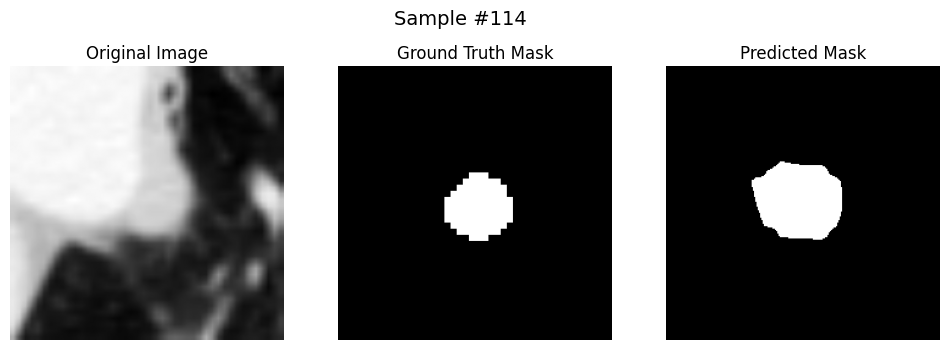

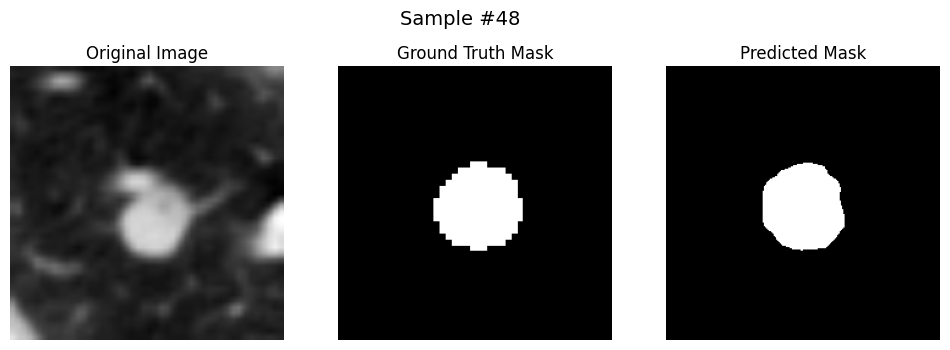

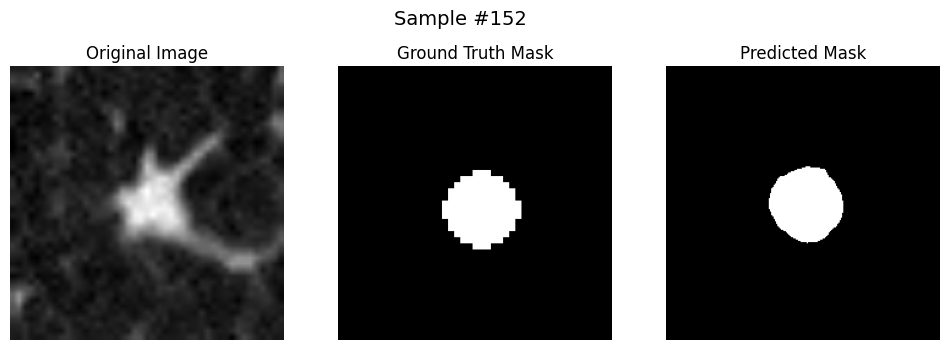

In [ ]:
num_samples = 3
indices = np.random.choice(len(X_val), num_samples, replace=False)

for idx in indices:
    img = X_val[idx, ..., 0]
    gt = Y_val[idx, ..., 0]
    pred = preds_val[idx, ..., 0]

    plt.figure(figsize=(12, 4))
    plt.suptitle(f"Sample #{idx}", fontsize=14)

    plt.subplot(1, 3, 1)
    plt.imshow(img, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(gt, cmap='gray')
    plt.title("Ground Truth Mask")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(pred > 0.5, cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

    plt.show()
